In [1]:
import numpy as np
import csv
import cv2
import random
import matplotlib.pylab as plt
%matplotlib inline
from data_adaptation import *

# Final Model

After trying what is described in [behavioral cloning](./Behavioral Cloning.ipnb), I tried to use what other students had been successful with and it was recommended by my mentor. I  tried to train both commaai model and nvidia. The car drove a little better but I still had many problems training it to go around the course. For that reason, I went back to basics.

By reading around I found that other people had been successful in training this models with far fewer samples that I have. In fact, by this time I was training the network on more that 100k samples depending on what filtering of the distribution I was doing. Therefore, I decided to check how well my model could represent the data. For that I was a lot more aggressive with cropping the image, and I added a resizing step that makes it a lot smaller.

The first step is reading the data to check its distribution.

## Data Distribution

In [2]:
data_folder = '../CarND-Data-P3/data_final/'
read_lines = []
bins = 200
samples_per_bin = 500

with open(data_folder + 'driving_log.csv') as csv_file:
    reader = csv.reader(csv_file)
    for line in reader:
        read_lines.append(line)
lines = np.array(read_lines[1:])

In [3]:
print('Total data lines from driving data: ', len(lines))
print('That makes a total data points after augmentation: ', 6 * len(lines))

Total data lines from driving data:  21153
That makes a total data points after augmentation:  126918


In [4]:
angles_list = []
for line in lines:
    angles_list.append(float(line[3].strip()))
angles = np.array(angles_list)

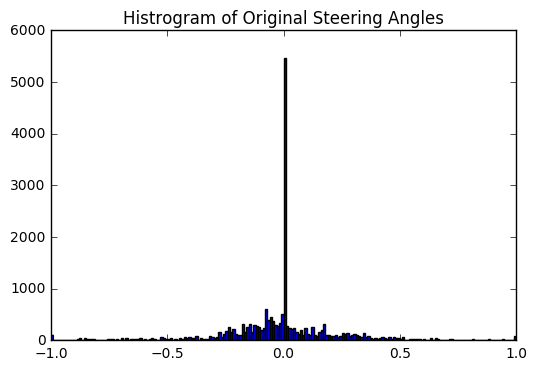

In [5]:
hist_original = plt.hist(angles, bins = bins)
title = plt.title('Histrogram of Original Steering Angles')

Even with all the new data compiled, which is mainly of curves and includes data from the challenge track, the distribution is still quite bias towards driving straight. What I did was limit the amount of samples that are selected for each bucket of the histogram. By setting that value, I can put a cap on how many samples are taken with 0 or close to 0 steering angle. 

In [6]:
used_samples = []
# make use extremes are included
hist_original[1][-1] += 0.0000001
bin_start = min(angles)
for bin_end in hist_original[1][1:]:
    selectable = np.where(np.logical_and(angles >= bin_start, angles < bin_end))
    samples_in_bin = len(angles[selectable])
    if samples_in_bin > samples_per_bin:
        idx = np.random.choice(samples_in_bin, samples_per_bin, replace=False)
        select_from = lines[selectable]
        used_samples.append(select_from[idx])
    else:
        used_samples.append((lines[selectable]))
    bin_start = bin_end
used_samples = np.concatenate(used_samples)

In [7]:
angles_list = []
for line in used_samples:
    angles_list.append(float(line[3].strip()))
used_angles = np.array(angles_list)

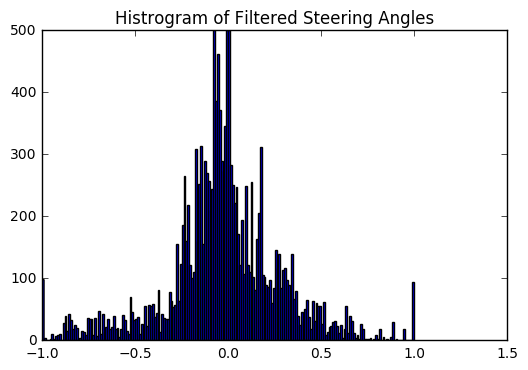

In [8]:
hist_mod = plt.hist(used_angles, bins = hist_original[1])
title = plt.title('Histrogram of Filtered Steering Angles')

In [9]:
print('Lines available after selection:', len(used_samples))
print('Samples available after selection:', len(used_samples) * 6)

Lines available after selection: 16060
Samples available after selection: 96360


Now, the samples to take for training look a lot closer to a normal distribution which should make it easier to train. After this filtering we still have 16060 data points. Taking into consideration data augmentation (left and right images plus mirroring) we still have 96360 samples to train with.

## Model

The first step would be to train it with a very limited set of data. That way, I can check if it can over-fit the data. This is an indication that it has sufficient expressive power. I felt the need to take that step because I reduced quite a bit the amount of information that I was passing to the model. After preprocesing, I passing a 64x32 pixel image to it. Let’s see how that data looks like.

### Original Samples

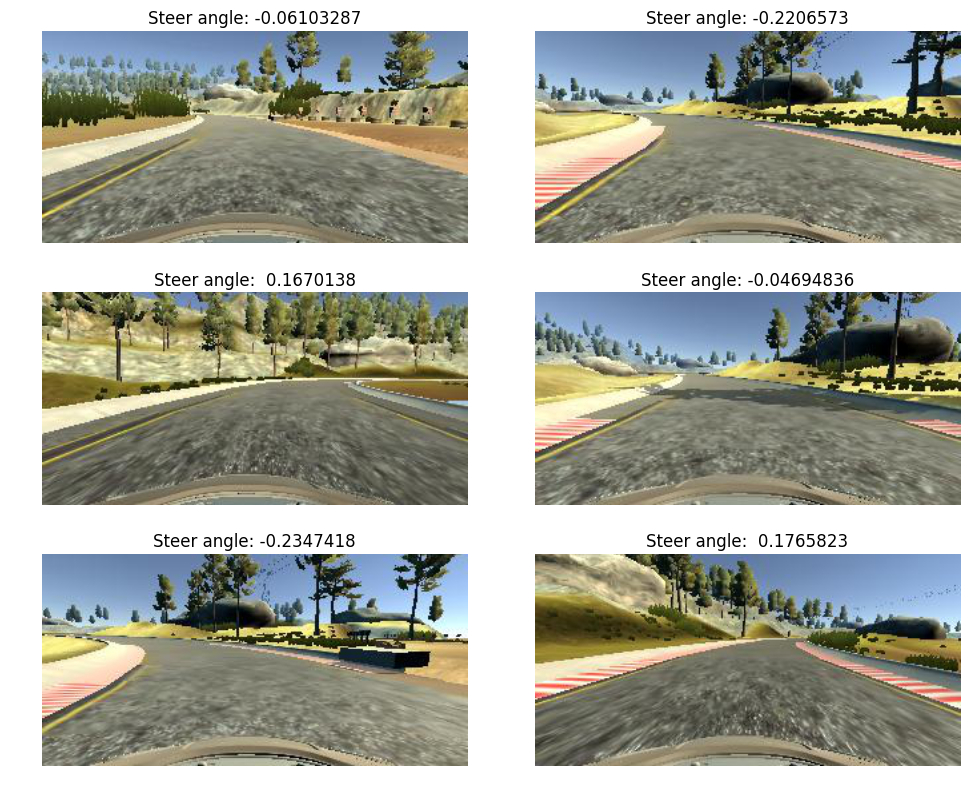

In [11]:
# select a few samples to work with
# list of samples for reference
example_lines = []
n = 3
m = 2
fig, ax = plt.subplots(n, m)
for a, sample in zip(ax.flatten(),range(n * m)):
    selected_test = np.random.randint(0, len(used_samples))
    line = used_samples[selected_test]
    example_lines.append(line)
    img = cv2.imread(data_folder + line[0].strip())
    a.imshow(toRGB(img))
    a.set_title('Steer angle: ' + line[3])
    a.axis('off')
fig.set_size_inches(10,8)
fig.tight_layout()

### Proccessed Samples

It is useful to take a look at what preprocessing is done and how the data that we’ll feed to the network looks like. Let’s take that small set of sample points and process it.

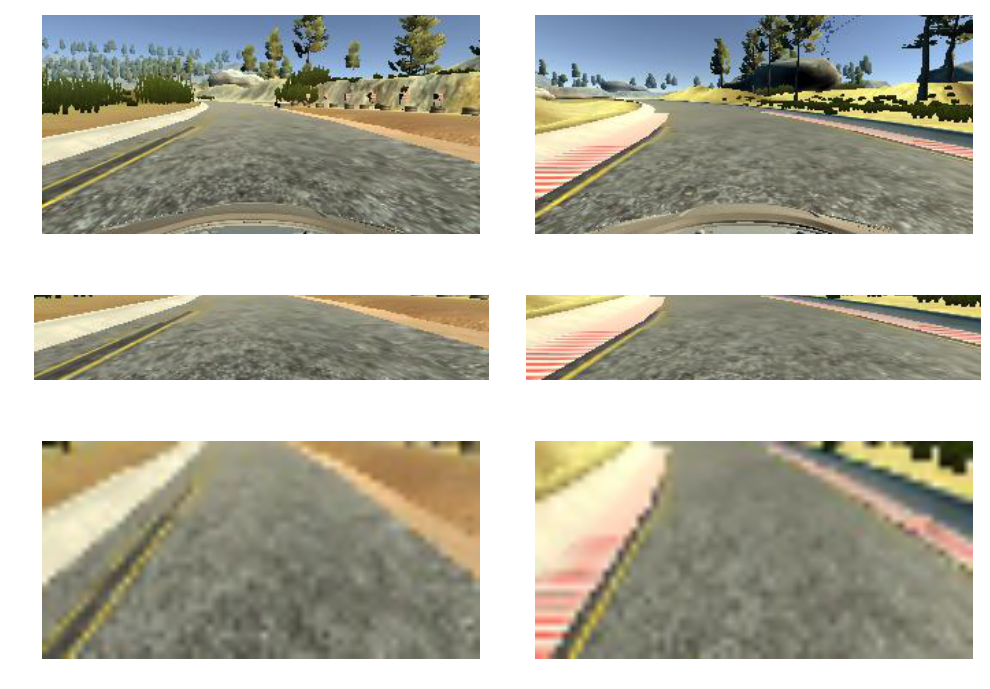

In [21]:
fig, ax = plt.subplots(n, m)

sample1 = data_folder + example_lines[0][0].strip()
sample2 = data_folder + example_lines[1][0].strip()
img1 = toRGB(cv2.imread(sample1))
img2 = toRGB(cv2.imread(sample2))

crop1 = img1[70:130, :]
crop2 = img2[70:130, :]
res1 = cv2.resize(crop1, (64,32))
res2 = cv2.resize(crop2, (64,32))
ax[0][0].imshow(img1)
ax[1][0].imshow(crop1)
ax[2][0].imshow(res1)
ax[0][1].imshow(img2)
ax[1][1].imshow(crop2)
ax[2][1].imshow(res2)
[a.axis('off') for a in ax.flatten()]
fig.set_size_inches(10,7)
fig.tight_layout()


### Model Description

The model is extensively based on commaai’s. After my bad experience before, I tried to make modifications that would go in line with improving learning.

In particular, I not only normalize the input with a lambda layer but also added a batch normalization layer before each non-linearity. From my previous results when a powerful network got stuck returning a small set of numbers, I had the suspicion that units may be “dying” during training. Normalizing the input to non linear units should help.

I also had tried different color spaces. In my previous attempt at training nvidia’s model, I had use YUV as it is described in their paper. However, in this case I found a nicer approach. I let the system learn the color space by starting with a 1 by 1 convolution and 3 filters. That way, during learning, the best color transformation is used.

Besides that, there is not much difference between commaai original model and mine. I played around a little with strides and filter sizes because my images are quite small, but that is about it.

At this point, I set to train the model. First, I tried a set of samples small enough that I knew it should overfit.

#### Overfit Model

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU
from keras.layers.convolutional import Convolution2D
from keras.callbacks import ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2

Using TensorFlow backend.


In [3]:
model = Sequential()
model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(h, w, 3)))
model.add(Convolution2D(3, (1, 1), strides=(1, 1), padding="same", kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(ELU())
model.add(Convolution2D(16, (5, 5), strides=(4, 4), padding="same", kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(ELU())
model.add(Convolution2D(32, (3, 3), strides=(2, 2), padding="same", kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(ELU())
model.add(Convolution2D(64, (3, 3), strides=(2, 2), padding="same", kernel_initializer='he_normal'))

model.add(Flatten())
model.add(Dropout(.2))
model.add(BatchNormalization())
model.add(ELU())
model.add(Dense(512, kernel_initializer='he_normal', kernel_regularizer=l2(0.001)))
model.add(Dropout(.5))
model.add(BatchNormalization())
model.add(ELU())
model.add(Dense(1))

model.compile(optimizer="adam", loss="mse", lr=0.001)

In [43]:
training = example_lines
print('Size of training set lines:', len(training))
print('Size of training set frames:', len(training) * 6)
X_train, y_train = get_training_data(training, data_folder)
# No need for validation, we want to overfit
model.fit(X_train, y_train, batch_size=16, validation_split=0.0, shuffle=True, epochs=200, verbose=0)
model.save('model_commaai_overfit.h5')

Size of training set lines: 6
Size of training set frames: 36


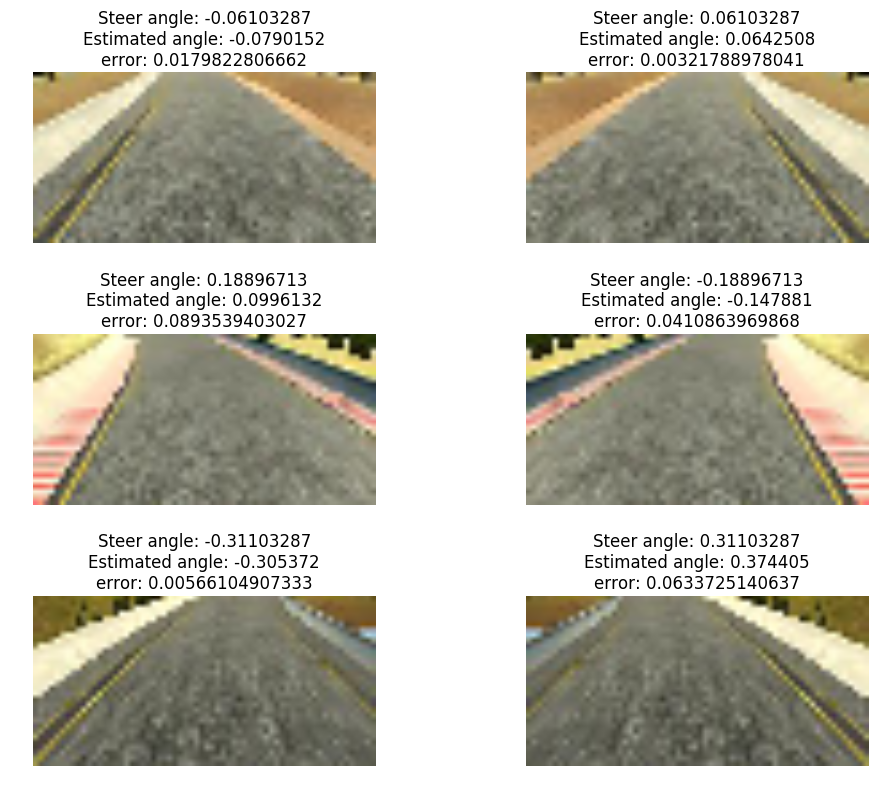

In [48]:
n = 3
m = 2
fig, ax = plt.subplots(n, m)
for a, sample, angle in zip(ax.flatten(), X_train, y_train):
    a.imshow(sample)
    steer_estimate = model.predict(sample[None,:,:,:], batch_size=1)[0][0]
    a.set_title('Steer angle: ' + str(angle) + '\n' + 'Estimated angle: ' + str(steer_estimate) + '\n' +
                'error: ' + str(abs(angle - steer_estimate)))
    a.axis('off')
fig.set_size_inches(10,8)
fig.tight_layout()

It takes quite a bit more training that I expected, but the samples are fitted somehow reasonably.

## Driving Model

With the model ready, I set it to train with all the data that I had collected. The data is preprocessed in the way I have described before in order to create a more balanced distribution. The code use to describe and train this final network is in [model.py](./model.py). This code makes use of some functions to process the data that are in [data_adaptation.py](./data_adaptation.py)

I also had to modify a little the code in drive.py as it need to crop and scale the image. That is done in the function process_img in data_adaptation.py

After only 5 epochs of training (I used early stopping), the model seemed to have converged. This are the results of applying it to our examples.

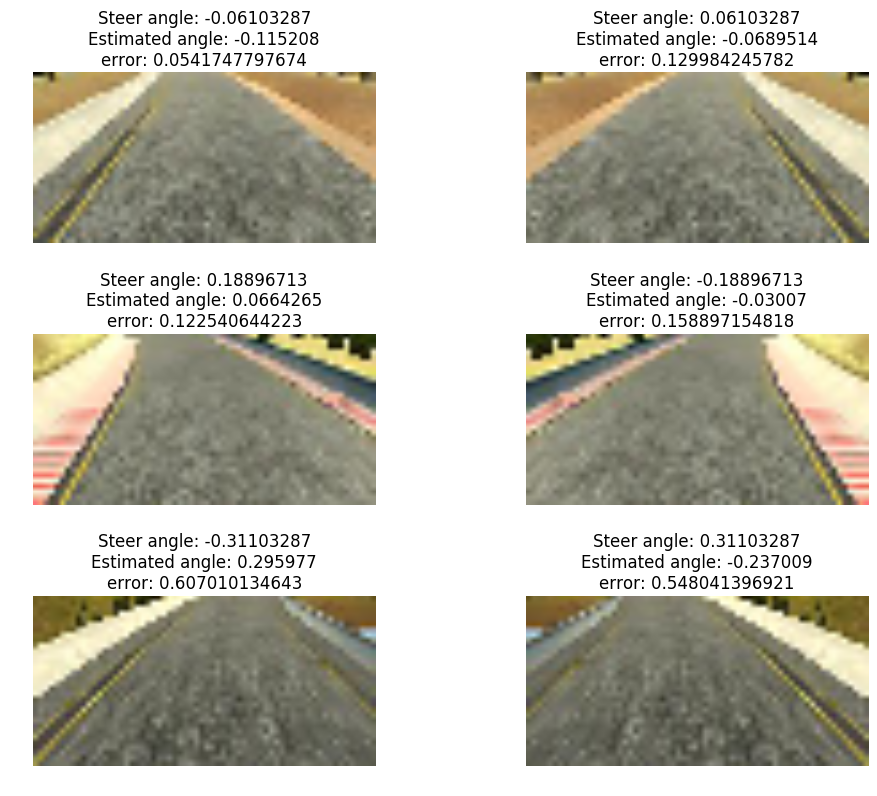

In [49]:
model.load_weights('model.h5')
n = 3
m = 2
fig, ax = plt.subplots(n, m)
for a, sample, angle in zip(ax.flatten(), X_train, y_train):
    a.imshow(sample)
    steer_estimate = model.predict(sample[None,:,:,:], batch_size=1)[0][0]
    a.set_title('Steer angle: ' + str(angle) + '\n' + 'Estimated angle: ' + str(steer_estimate) + '\n' +
                'error: ' + str(abs(angle - steer_estimate)))
    a.axis('off')
fig.set_size_inches(10,8)
fig.tight_layout()

Numerical error does not seem too good. However, from previous experiments it was clear that this was not a perfect indicator by any means. By testing the model in the track, I could check that it was able to drive around it continuously at 9 mph. I increased the speed to 15 mph. At this speed the car’s behavior is quite erratic, but it still goes around. One can start seen some indication of instability in the control of the car. I left the speed at 12 and that is what is shown in the video.

## Conclusion

After a lot of different test I came to a very similar conclusion than before. As a methodology I think it is much better to come from a simple model and complicate it later than to start from a complex one an try to simplify it. In this case, it is interesting to notice how just a 64x32 image conveys enough information to drive the car around. That is some that I would consider any other time I have to do deep learning.

This is the summary of the model:

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 32, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 64, 3)         12        
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 64, 3)         12        
_________________________________________________________________
elu_1 (ELU)                  (None, 32, 64, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 16, 16)         1216      
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 16, 16)         64        
_________________________________________________________________
elu_2 (ELU)                  (None, 8, 16, 16)         0         
__________